# Cleaning files to match the format

In [34]:
import os
import re

# Define the folder containing the text files
folder_path = "../files/data/FA7000-15-D-0006-9011/SINGLE_DATABASES_Rt5d0_17Sep2019"

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    
    # Read the file content
    with open(file_path, 'r') as file:
        global W_R
        content = file.readlines()
        line = content[1]
        values = line.strip().split()
        if values[0] == "Geometry:":
            # Use regex to extract the Width/radius value
            # match = re.search(r"Width/radius=(\d+\.\d+)", line)
            match = re.search(r"(\d+\.\d+)\*R", line)
            if match:
                W_R = match.group(1)  # Extract the matched value
        else:
            print("Something is wrong with: ", filename)
    
    # Modify lines that start with "Results for crack number:"
    updated_content = []
    for line in content:
        if line.startswith("Results for crack number:"):
            # Add "W/R=[W_R]," after "Results for"
            updated_line = re.sub(
                r"(Results for )",
                rf"\1W/R = {W_R}, ",
                line
            )
            updated_content.append(updated_line)
        else:
            updated_content.append(line)
    
    # Write the updated content back to the file
    with open(file_path, 'w') as file:
        file.writelines(updated_content)

print("Modification completed!")

Modification completed!


# Dependencies

In [35]:
import numpy as np
import pandas as pd
import os
from concurrent.futures import ThreadPoolExecutor

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from scipy.interpolate import PchipInterpolator

from tqdm import tqdm

# Working on...

In [36]:
# Specify the directory path
dir_path = "../files/data/"

# Get folder names
master_folders = [f for f in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, f))]

print(master_folders)

['BH_SINGLE', 'FA700021D0002-23F0143', 'FA7000-15-D-0006-9011', 'FA700021D0002-22F0214']


In [37]:
master_folder = master_folders[2]

# Specify the directory path
dir_path = "../files/data/{}".format(master_folder)

# Get folder names
folders = [f for f in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, f))]

print(folders)

['SINGLE_DATABASES_Rt2_3Apr2019', 'SINGLE_DATABASES_Rt1d5_17Sep2019', 'SINGLE_DATABASES_Rt5d0_17Sep2019', 'SINGLE_DATABASES_Rt3d0_8May2019', 'FortyDbases', 'SINGLE_DATABASES_Rt0d5_17Sep2019', 'SINGLE_DATABASES_Rt1d0_8Mar2019', 'SINGLE_DATABASES_Rt2d0_3Apr2019', 'SINGLE_DATABASES_8Mar2019']


# .DAT to .csv

In [38]:
def process_file(file_info):
    input_file_path, output_file_path = file_info
    
    rows = []
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

        W_R = None
        a_c, a_t, r_t, b_t = None, None, None, None
        crack = False

        for i, line in enumerate(lines):
            values = line.strip().split()
            if not values:
                continue

            if values[0] == "Results":
                W_R = float(values[4][:-1])

            elif values[0] == "ndom":
                crack = False
                next_values = lines[i + 1].strip().split()
                a_c, a_t, r_t, b_t = map(float, next_values[1:5])

            elif values[0] == "crack":
                crack = True

            elif values[0].isdigit() and crack:
                row = [W_R, a_c, a_t, r_t, b_t] + list(map(float, values[6:10]))
                rows.append(row)

    df = pd.DataFrame(rows, columns=['W/R', 'a/c', 'a/t', 'r/t', 'b/t', 'phi', 'K-T', 'K-B', 'K-P'])
    df.to_csv(output_file_path, index=False)

tasks = []

for folder in folders:
    dir_path = os.path.join("../files/data", master_folder, folder)
    files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]

    for file_name in files:
        input_file_path = os.path.join(dir_path, file_name)
        output_file_path = os.path.join(dir_path, f"{file_name[:-4]}.csv")
        tasks.append((input_file_path, output_file_path))

# Process files in parallel
with ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(process_file, tasks), total=len(tasks), desc="Processing Files"))
    # executor.map(process_file, tasks)


Processing Files: 100%|██████████| 175/175 [01:28<00:00,  1.98it/s]


# One .csv for each b/t

In [39]:
for folder in folders:
    # Specify the directory path
    dir_path = "../files/data/{}/{}".format(master_folder, folder)

    # Get all .csv files
    csv_files = [f for f in os.listdir(dir_path) if f.endswith(".csv")]

    print(csv_files)

    df = pd.read_csv("../files/data/{}/{}/{}".format(master_folder, folder, csv_files[0]))
    # df = df.drop(columns=["b/t"])
    df = df.drop(df[df['phi'] == 0].index)
    df = df.drop(df[df['K-T'] == 0].index)
    df = df.drop(df[df['K-B'] == 0].index)
    df = df.drop(df[df['K-P'] == 0].index)
    df.dropna(inplace=True)

    for index in csv_files[1:]:
        df_ = pd.read_csv("../files/data/{}/{}/{}".format(master_folder, folder, index))
        # df_ = df_.drop(columns=["b/t"])
        df_ = df_.drop(df_[df_['phi'] == 0].index)
        df_ = df_.drop(df_[df_['K-T'] == 0].index)
        df_ = df_.drop(df_[df_['K-B'] == 0].index)
        df_ = df_.drop(df_[df_['K-P'] == 0].index)
        df_.dropna(inplace=True)
        df = pd.concat([df, df_], axis=0, ignore_index=True)

    df.to_csv("../files/data/{}/{}.csv".format(master_folder, folder), index=False)

['CS_SINGLE_WR_4d0_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_5d2_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_40d0_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_20d0_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_8d0_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_2d4_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_6d4_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_10d0_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_12d0_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_4d6_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_100d0_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_30d0_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_2d8_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_9d0_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_16d0_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_2d6_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_3d2_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_5d8_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_3d6_hW_1d0_Rt_2d0_bt_0d5.D.csv', 'CS_SINGLE_WR_7d0_hW_1d0_Rt_2d0_bt_0d5.D.csv']
['CS_SINGLE_WR_7d0_hW_1d0_Rt_1d5_bt_0d5.D.csv', 'CS

# Viz each .csv

In [40]:
# Specify the directory path
dir_path = "../files/data/{}".format(master_folder)

# Get all .csv files
csv_files = [f for f in os.listdir(dir_path) if f.endswith(".csv")]

print(csv_files)

['SINGLE_DATABASES_Rt5d0_17Sep2019.csv', 'SINGLE_DATABASES_8Mar2019.csv', 'FortyDbases.csv', 'SINGLE_DATABASES_Rt0d5_17Sep2019.csv', 'SINGLE_DATABASES_Rt2_3Apr2019.csv', 'SINGLE_DATABASES_Rt1d5_17Sep2019.csv', 'SINGLE_DATABASES_Rt2d0_3Apr2019.csv', 'SINGLE_DATABASES_Rt1d0_8Mar2019.csv', 'SINGLE_DATABASES_Rt3d0_8May2019.csv']


Working On: SINGLE_DATABASES_Rt5d0_17Sep2019.csv
Different combinations:  3775

Different W/r values:  [ 2.4  2.6  2.8  3.2  3.6  4.   4.6  5.2  5.8  6.4  7.   8.   9.  10.
 12.  16.  20.  30.  40. ]
Different a/c values:  [ 0.1     0.125   0.1667  0.2     0.25    0.333   0.5     0.667   0.75
  0.8     0.9     1.      1.1111  1.25    1.333   1.5     2.      3.
  6.     10.    ]
Different a/t values:  [0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.95]
Different r/t values:  [5.]
Different b/t values:  [0.5]


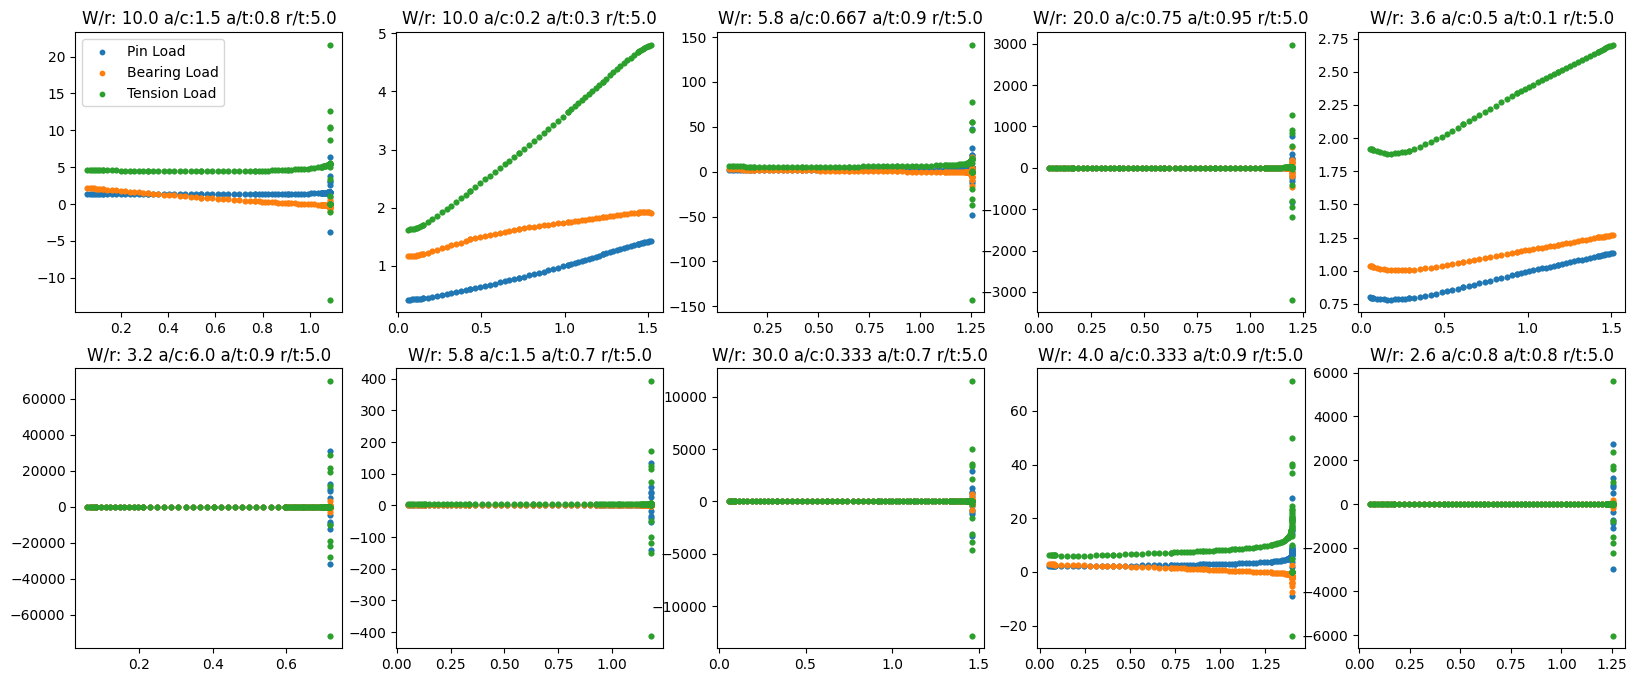

Working On: SINGLE_DATABASES_8Mar2019.csv
Different combinations:  3630

Different W/r values:  [  2.4   2.6   2.8   3.2   3.6   4.    4.6   5.2   5.8   6.4   7.    8.
   9.   10.   12.   16.   20.   30.   40.  100. ]
Different a/c values:  [ 0.1     0.125   0.1667  0.2     0.25    0.333   0.5     0.667   0.75
  0.8     0.9     1.      1.1111  1.25    1.333   1.5     2.      3.
  6.     10.    ]
Different a/t values:  [0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.95]
Different r/t values:  [1.]
Different b/t values:  [0.5]


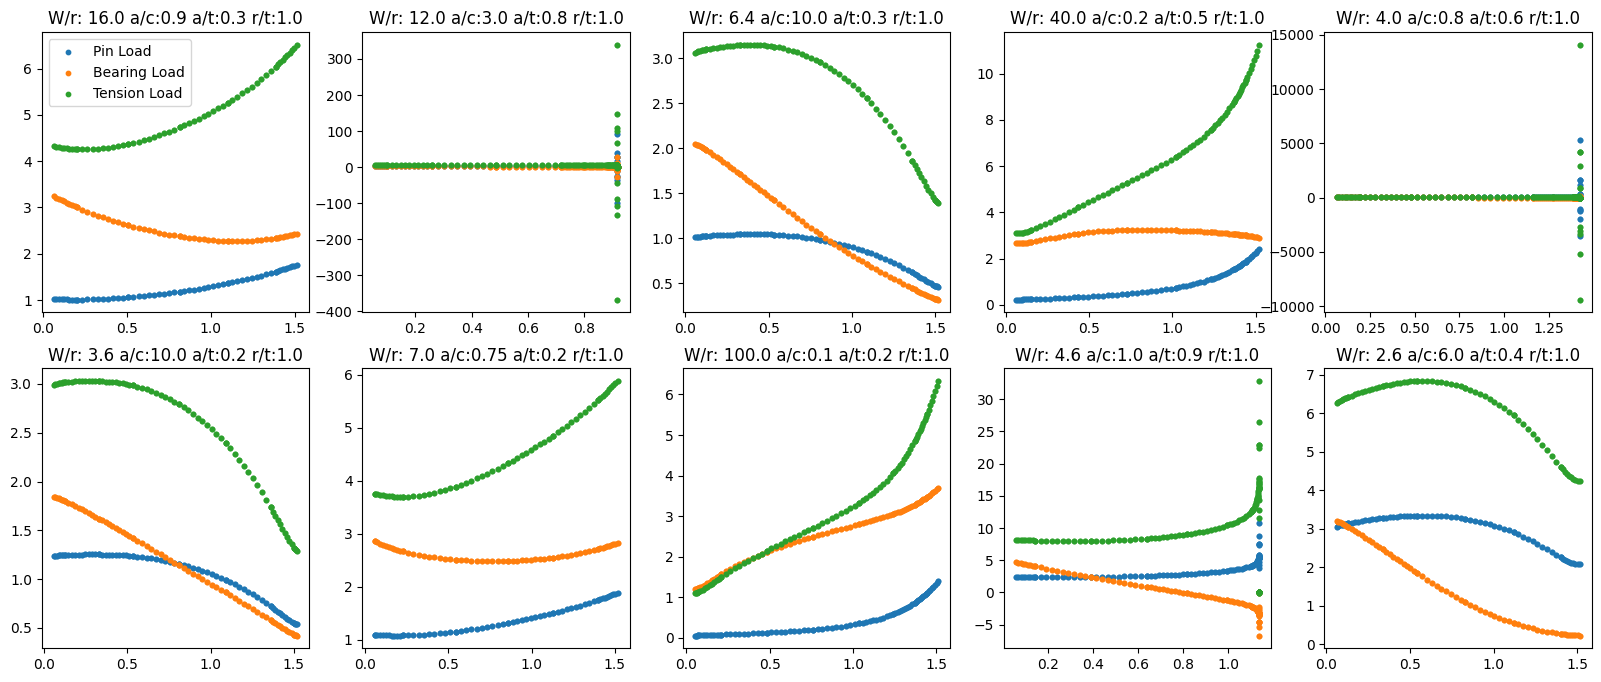

Working On: FortyDbases.csv
Different combinations:  1556

Different W/r values:  [  2.4   2.6   2.8   3.2   3.6   4.    4.6   5.2   5.8   6.4   7.    8.
   9.   10.   12.   16.   20.   30.   40.  100. ]
Different a/c values:  [ 0.1     0.125   0.1667  0.2     0.25    0.333   0.5     0.667   0.75
  0.8     0.9     1.      1.111   1.25    1.333   1.5     2.      3.
  6.     10.    ]
Different a/t values:  [0.1 0.2 0.3 0.4]
Different r/t values:  [1.]
Different b/t values:  [0.5]


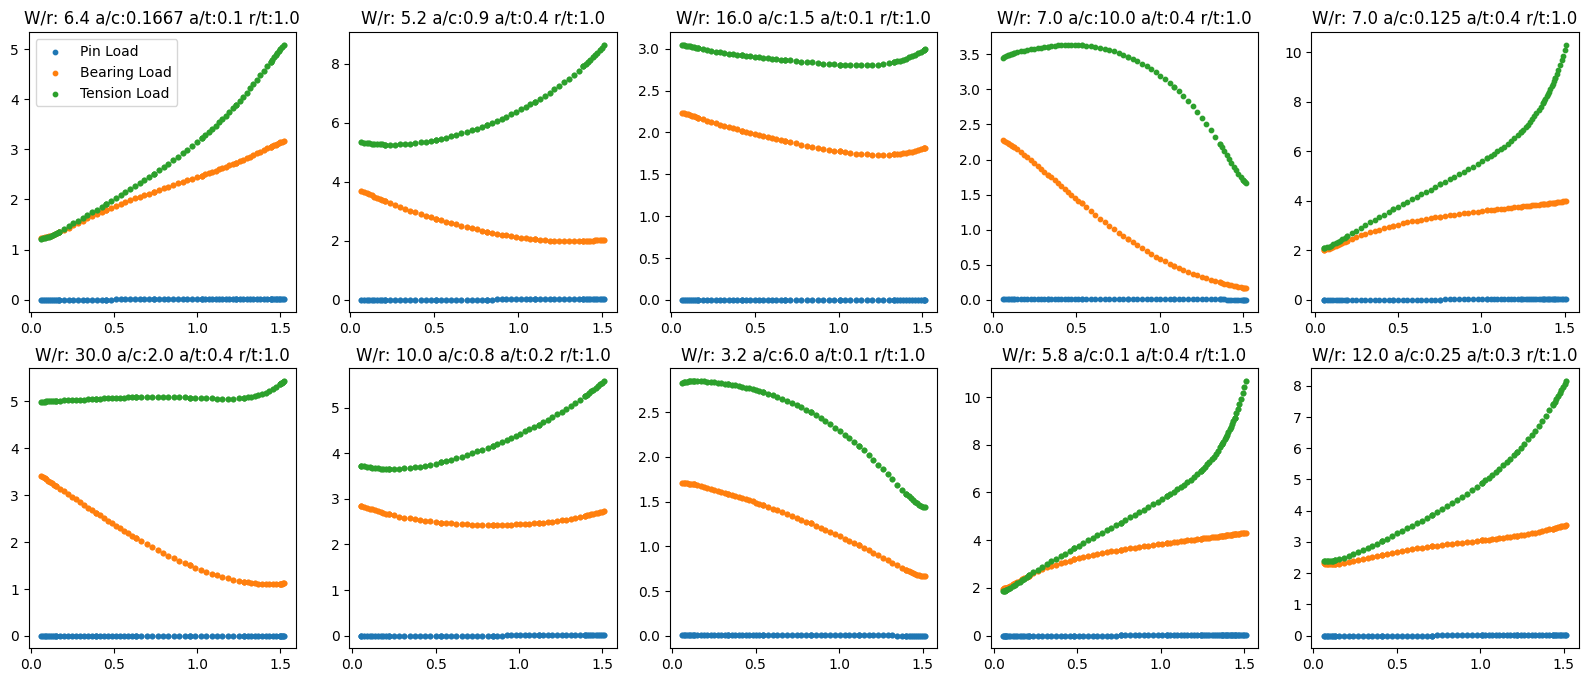

Working On: SINGLE_DATABASES_Rt0d5_17Sep2019.csv
Different combinations:  2946

Different W/r values:  [  3.2   3.6   4.    4.6   5.2   5.8   6.4   7.    8.    9.   10.   12.
  16.   20.   30.   40.  100. ]
Different a/c values:  [ 0.1     0.125   0.1667  0.2     0.25    0.333   0.5     0.667   0.75
  0.8     0.9     1.      1.1111  1.25    1.333   1.5     2.      3.
  6.     10.    ]
Different a/t values:  [0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.95]
Different r/t values:  [0.5]
Different b/t values:  [0.5]


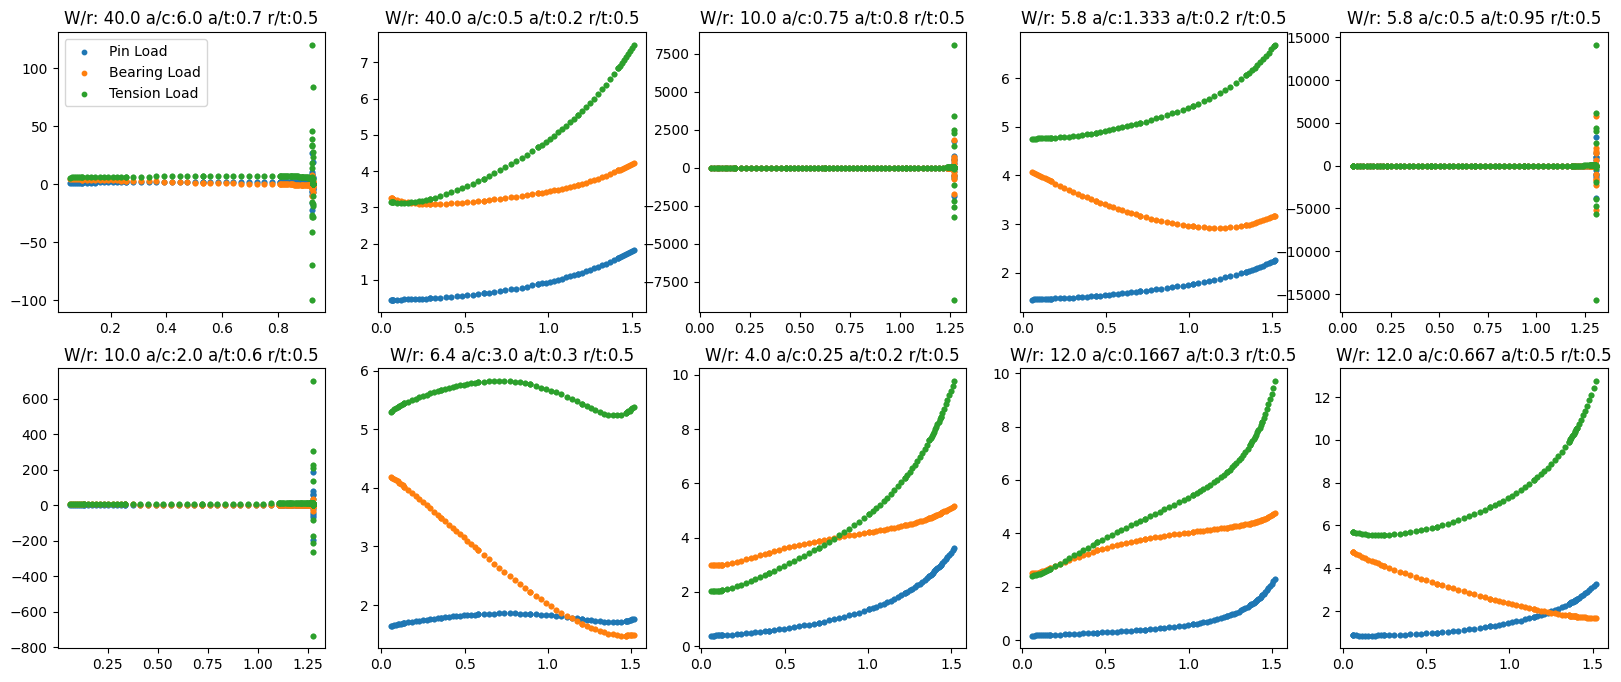

Working On: SINGLE_DATABASES_Rt2_3Apr2019.csv
Different combinations:  3840

Different W/r values:  [  2.4   2.6   2.8   3.2   3.6   4.    4.6   5.2   5.8   6.4   7.    8.
   9.   10.   12.   16.   20.   30.   40.  100. ]
Different a/c values:  [ 0.1     0.125   0.1667  0.2     0.25    0.333   0.5     0.667   0.75
  0.8     0.9     1.      1.1111  1.25    1.333   1.5     2.      3.
  6.     10.    ]
Different a/t values:  [0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.95]
Different r/t values:  [2.]
Different b/t values:  [0.5]


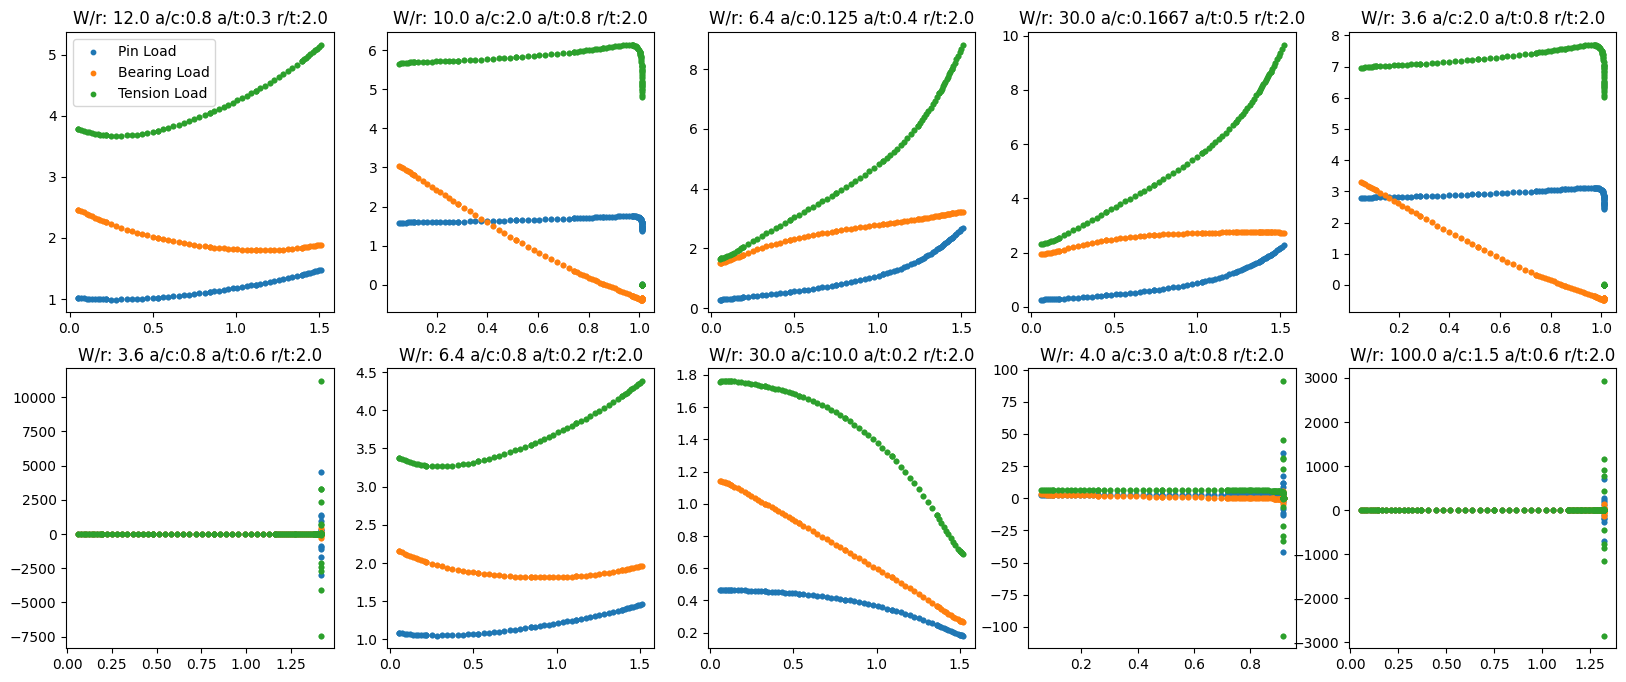

Working On: SINGLE_DATABASES_Rt1d5_17Sep2019.csv
Different combinations:  3754

Different W/r values:  [  2.4   2.6   2.8   3.2   3.6   4.    4.6   5.2   5.8   6.4   7.    8.
   9.   10.   12.   16.   20.   30.   40.  100. ]
Different a/c values:  [ 0.1     0.125   0.1667  0.2     0.25    0.333   0.5     0.667   0.75
  0.8     0.9     1.      1.1111  1.25    1.333   1.5     2.      3.
  6.     10.    ]
Different a/t values:  [0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.95]
Different r/t values:  [1.5]
Different b/t values:  [0.5]


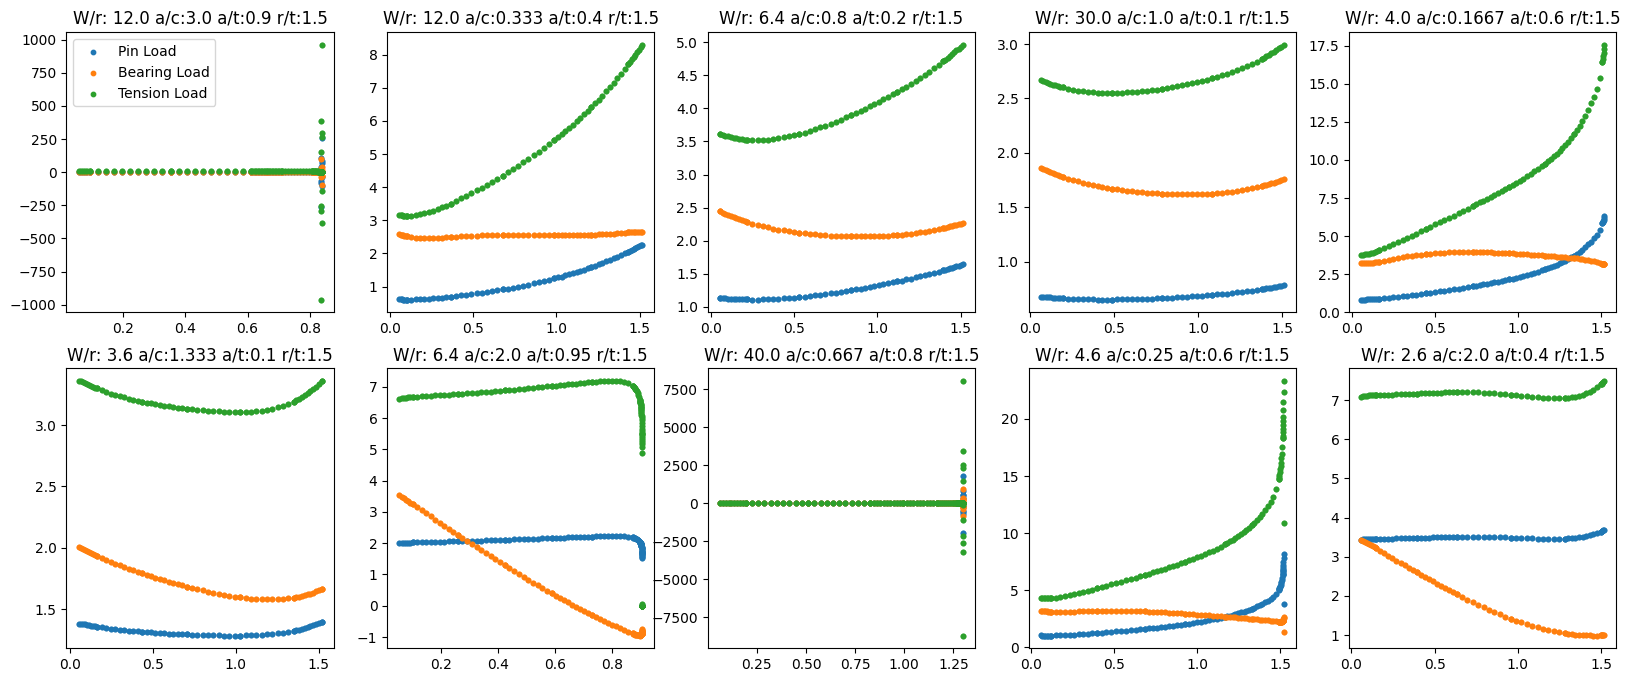

Working On: SINGLE_DATABASES_Rt2d0_3Apr2019.csv
Different combinations:  3840

Different W/r values:  [  2.4   2.6   2.8   3.2   3.6   4.    4.6   5.2   5.8   6.4   7.    8.
   9.   10.   12.   16.   20.   30.   40.  100. ]
Different a/c values:  [ 0.1     0.125   0.1667  0.2     0.25    0.333   0.5     0.667   0.75
  0.8     0.9     1.      1.1111  1.25    1.333   1.5     2.      3.
  6.     10.    ]
Different a/t values:  [0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.95]
Different r/t values:  [2.]
Different b/t values:  [0.5]


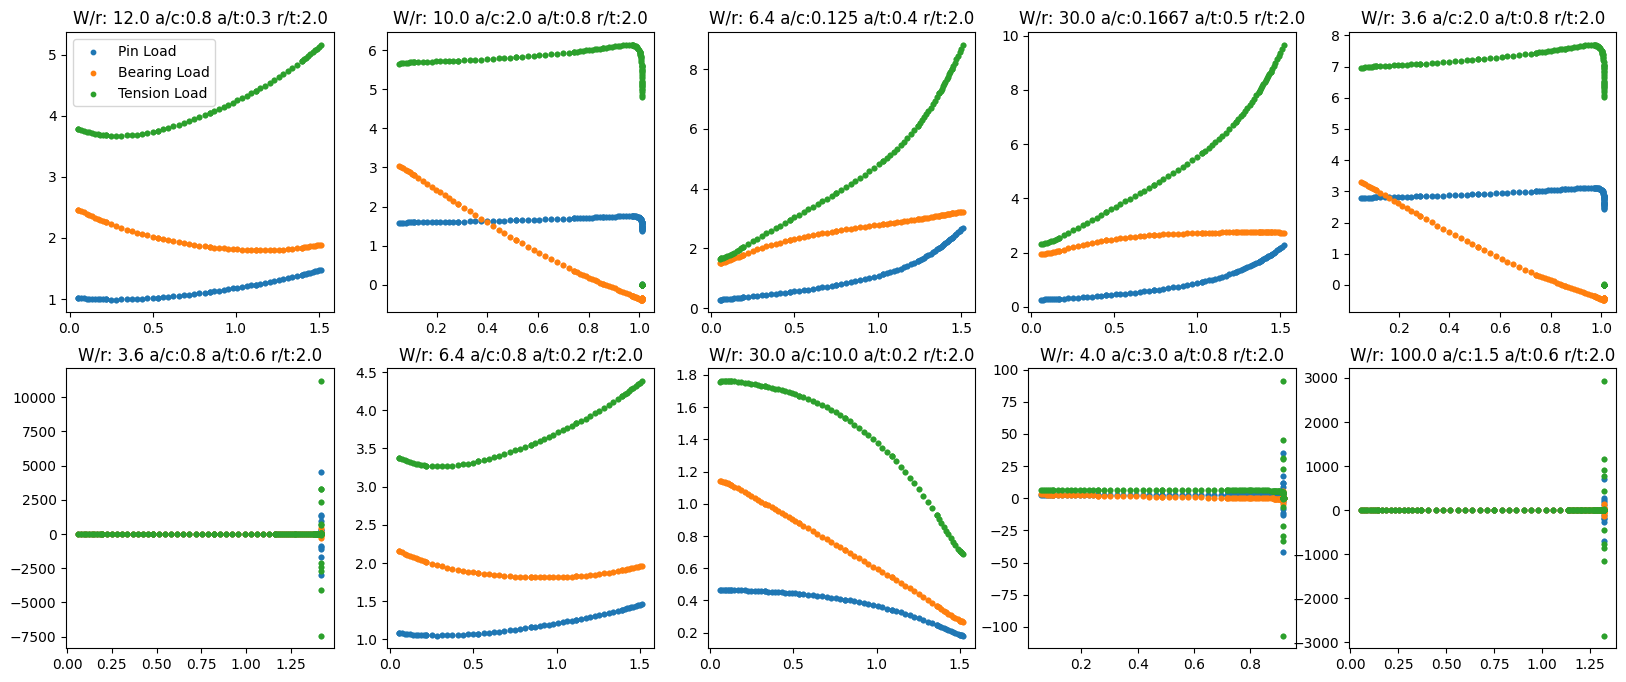

Working On: SINGLE_DATABASES_Rt1d0_8Mar2019.csv
Different combinations:  3630

Different W/r values:  [  2.4   2.6   2.8   3.2   3.6   4.    4.6   5.2   5.8   6.4   7.    8.
   9.   10.   12.   16.   20.   30.   40.  100. ]
Different a/c values:  [ 0.1     0.125   0.1667  0.2     0.25    0.333   0.5     0.667   0.75
  0.8     0.9     1.      1.1111  1.25    1.333   1.5     2.      3.
  6.     10.    ]
Different a/t values:  [0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.95]
Different r/t values:  [1.]
Different b/t values:  [0.5]


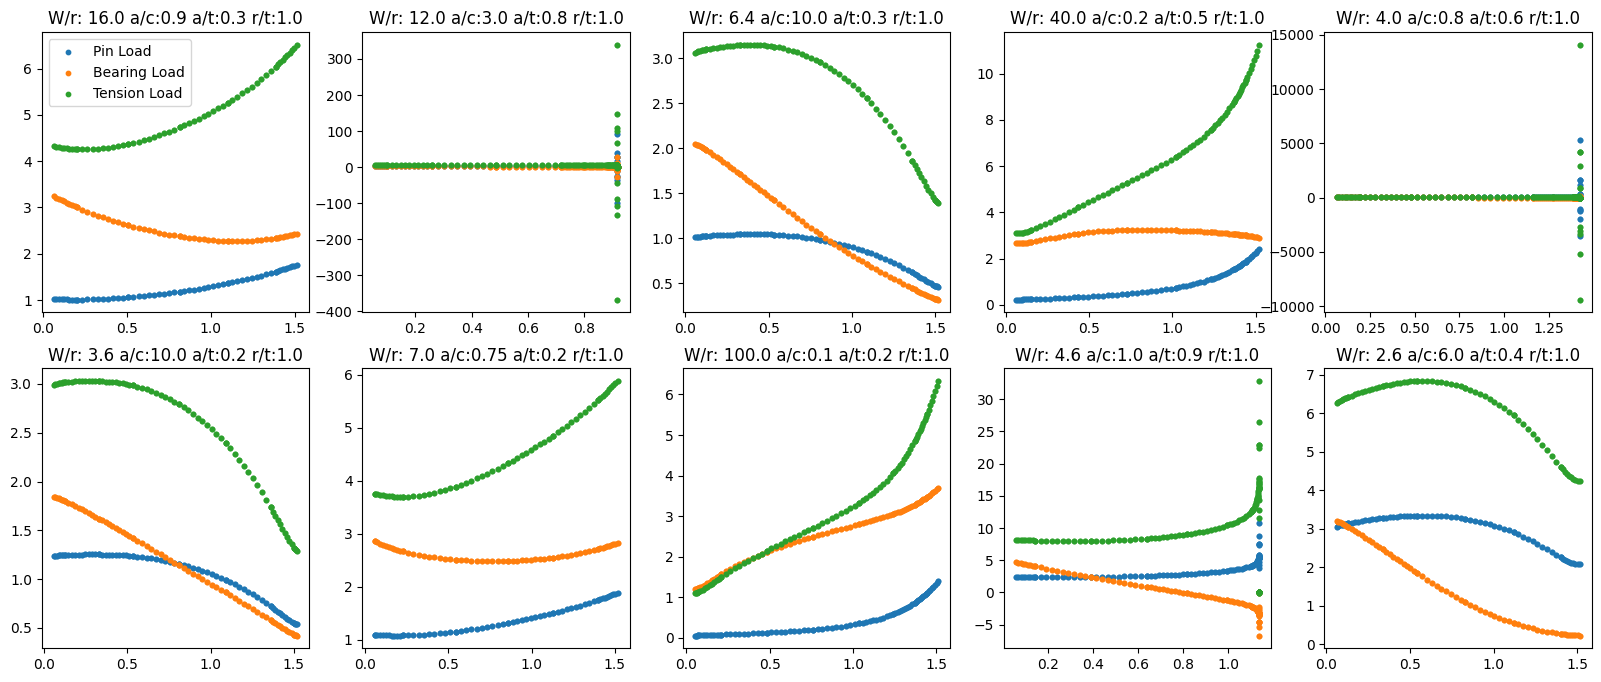

Working On: SINGLE_DATABASES_Rt3d0_8May2019.csv
Different combinations:  3714

Different W/r values:  [ 2.4  2.6  2.8  3.2  3.6  4.   4.6  5.2  5.8  6.4  7.   8.   9.  10.
 12.  16.  20.  30.  40. ]
Different a/c values:  [ 0.1     0.125   0.1667  0.2     0.25    0.333   0.5     0.667   0.75
  0.8     0.9     1.      1.1111  1.25    1.333   1.5     2.      3.
  6.     10.    ]
Different a/t values:  [0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.95]
Different r/t values:  [3.]
Different b/t values:  [0.5]


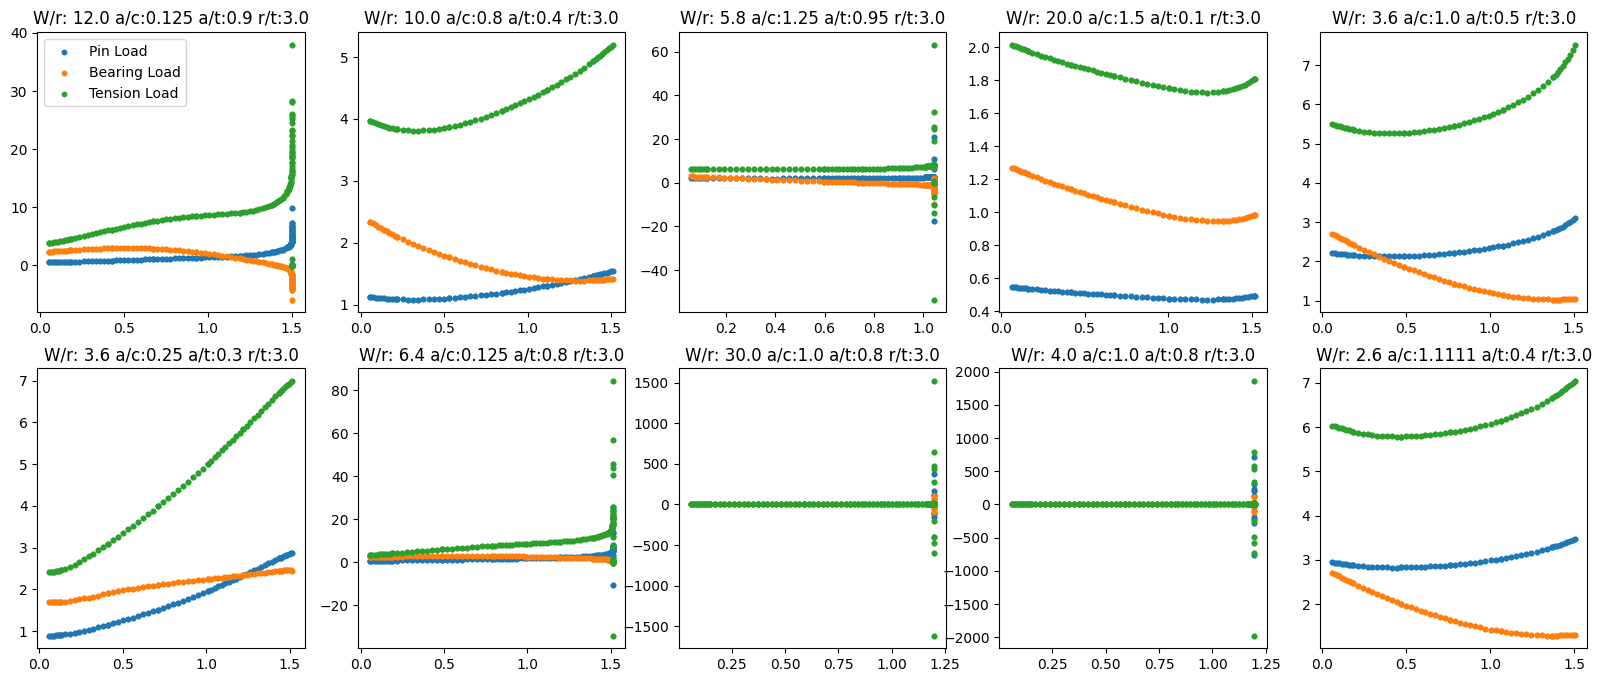

In [41]:
for file in csv_files:
    print("========================")
    print("Working On: {}".format(file))
    print("========================")
    df = pd.read_csv("../files/data/{}/{}".format(master_folder, file))
    d = df.to_numpy()

    # Getting all a/c, a/t and c/b combinations
    CC_combinations = [d[0,:5]]

    for line in d:
        if (line[:5] == CC_combinations[-1]).all():
            continue
        else:
            CC_combinations.append(line[:5])

    CC_combinations = np.unique(CC_combinations, axis=0)

    print("Different combinations: ", len(CC_combinations))
    
    print("")

    print("Different W/r values: ", np.unique(CC_combinations[:,0], axis=0))
    print("Different a/c values: ", np.unique(CC_combinations[:,1], axis=0))
    print("Different a/t values: ", np.unique(CC_combinations[:,2], axis=0))
    print("Different r/t values: ", np.unique(CC_combinations[:,3], axis=0))
    print("Different b/t values: ", np.unique(CC_combinations[:,4], axis=0))

    np.random.seed(0)
    fig, axs = plt.subplots(2, 5, figsize=(20,8))
    for i in range(2):
        for j in range(5):
            idx = np.random.randint(0, len(CC_combinations))
            combination = CC_combinations[idx]
            indices = np.where((d[:, 0] == combination[0]) & 
                            (d[:, 1] == combination[1]) &
                            (d[:, 2] == combination[2]) &
                            (d[:, 3] == combination[3]) &
                            (d[:, -4] >= np.max(np.unique(0.052))) & 
                            (d[:, -4] <= np.min(np.unique(1.52))))
            indices = indices[0]
            axs[i,j].scatter(d[indices][:,-4], d[indices][:,-1], label="Pin Load", s=10)
            axs[i,j].scatter(d[indices][:,-4], d[indices][:,-2], label="Bearing Load", s=10)
            axs[i,j].scatter(d[indices][:,-4], d[indices][:,-3], label="Tension Load", s=10)
            axs[i,j].set_title("W/r: {} a/c:{} a/t:{} r/t:{}".format(combination[0], combination[1], combination[2], combination[3]))
            
            if i == 0 and j == 0:
                axs[i,j].legend()
    plt.show()